# Visualizing and Understanding Convolutional Networks

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from PIL import Image

## Summary

Although there exist several experiments that show deep learning methods such as ConvNets perform extremely well on the image classification tasks, almost no literature exists about what happens inside a deep network. They are often described as black boxes so experimentation is reduced to trail and error. The authors attempt to accommedate these issues by developing a set of visualisation techniques to better understand what the network learns. To understand what happens inside an ConvNet, the Zeiler et al. visualises the feature activity using deconvolutional network. 

The use of decovnet for feature visualisation allows them to present compelling evidence what convolutional filters at different layers learn. At the first layer, the filters can edge and colour blob detectors at different orientations. In the second layer, the model learns complex patterns consisting of multiple edge patterns to make parallel lines, curves, circles, T-junctions etc. Layer 3 learns textures such mesh patterns and text pattern. Layer 4 learns class-specific and semantically related feature such as dog faces bird's legs. The last convolutional layer before the classification layer learns high-level object features such as keyboards and dogs. The authers use the lessons learned by the ConvNet visualisations to makes changes to AlexNet so performs even better on ImageNet.

The paper also investigates other areas related to visualisation:
- What are the evolution of convolutional filters during training?
- What is the effect of translation, scaling and rotation of images?
- Does a ConvNets look at the right regions of an image to perform its classification?
- Are the any correspondance mechanisms learned by a ConvNet?



## Related Work

Two related works:

- Visualise filters by finding an image that maximises the activation of a given filter. Proposed in 2009 by Erhan et. al. in "Visualizing Higher-Layer Features of a Deep Network". The issues with this method is that 
  1. This requires a careful initialization
  2. Does not give any information about the unit's invariances

<img src="https://drive.google.com/uc?id=1IeLCnjSvBLwGyWSYXgJke7Gobt259kS5" width="500" />



- Compute the Hessian of a given filter numerically around the optimal response. The problem is that for higher layers, the invariances are extremely complex so are poorly captured by a simple quadratic approximation.

## Their Approach

- Train a normal CNN based on the AlexNet architecture
- Map activations back to the image space using Deconvolutional Network (deconvnet)
  - DeconvNet allows us to see which pattern in the input image caused an activation
- Each layer of the normal ConvNet is attached to a corresponding layer of DeconvNet layer

<img src="figures/p4/convnet-with-deconvnet.png" width="400" />




- Pick a layer that you want to visualise e.g. layer 3
- Pick a filter that you want to visualise e.g. filter 42
- Feed an input image to the ConvNet and compute the feature maps through to the layer 3
- Select a pooled map corresponding to the selected filter
- Find the strongest activation in that pooled map
  - This indicate what part of the original input image is highly excited by the filter
- Set all other activations in that layer to zero.
- Pass the feature maps as input to the attached deconvnet layer.
- Perform following operations all the way to the input pixel space:
  - unpool
  - rectify
  - deconvolve

So for each image, we get back two things:
- a bounding box indicating the region of the original input for which the chosen filter is highly activated
- a recontructed image

The authors use 50,000 images (from ImageNet 2012 validation set) as input.

They pick the 9 strongest activations from entire 50k images.



<img src="figures/p4/reconstruction.png" width="400" />




### Unpooling

- In the convnet, the max pooling operation is non-invertible
- An approximate inverse can be found by recording the locations of the maxima within each pooling region
- The **switch** variables record the locations of the maxima within each pooling
- The unpooling operation uses these switches for the reconstruction (set the other locations to zero)
- As these switch settings are peculiar to a given input image, the reconstruction obtained from a single activation thus resembles a small piece of the original input image.

<img src="figures/p4/reversible-max-pooling.png" width="600" />




### Rectification

- Reconstructed image is then passed through a ReLU function
- **Do not understand why though because the unpooling operation returns only positive numbers**

### Deconvolution

- To inverse the convolution operation, a transposed version of the same filter is applied to the rectified map from the layer above
- In practice this means flipping each filter vertically and horizontally.

#### Digression

Convolving an input $\mathbf{x}\in \mathbb{R}^{n}$ with a filter $\mathbf{h}\in \mathbb{R}^{m}$  can be seen as a matrix multiplication where the filter weights are converted into a Toeplitz matrix $\mathbf{H}$.

<img src="figures/p4/convolution-as-matrix-multiplication.png" width="400" />




To simply things, we assume that the columns of $\mathbf{H}$ are orthorgonal (not always true). This means that the columns of $\mathbf{H}$ can be seen as basis vectors to some transformation.

The output $\mathbf{y}$ is the output of the transformation:
$$
\mathbf{y} = \mathbf{H} \mathbf{x}
$$

A deconvolution operation is the inverse of the convolution operation, so if we wanted to obtain the original input given the output, we can:
$$
\mathbf{x} = \mathbf{H}^{-1} \mathbf{y}
$$

Since $\mathbf{H}$ is orthogonal, its inverse is the same as its transpose. Therefore, the deconvolutional operation can be done as follows:

$$
\mathbf{x} = \mathbf{H}^{T} \mathbf{y}
$$

However, in practice the trained convolutional filters are not invertible. So we cannot get our original image back. Here is an example:

In [2]:
def display_image(img_array):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.imshow(img_array, cmap='gray')
    ax.axis('off')

In [3]:
# Load image in greyscale
img = Image.open("figures/alaskan-malmute.jpg").convert('L')
img_arr = (np.array(img, np.float32) - 128.0) / 128.0

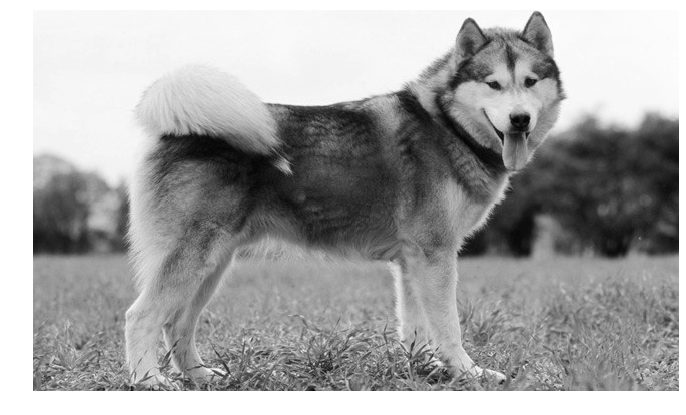

In [4]:
display_image(img_arr)

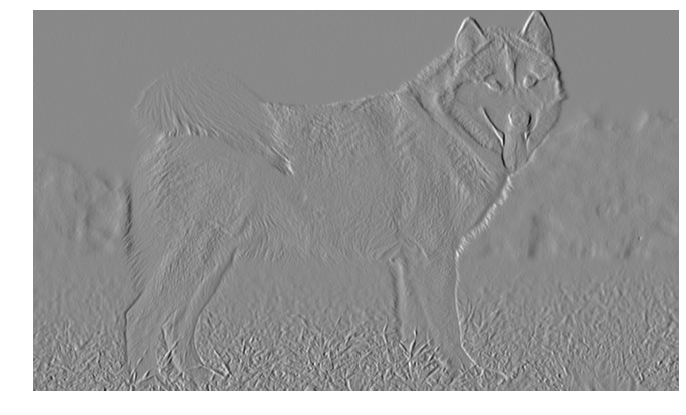

In [5]:
# Edge detection kernel (Sobel operator)
kernel = np.array([ [-1,0,1],
                    [-2,0,2],
                    [-1,0,1] ])
# Convolve the image with the kernel
filtered_image = ndimage.convolve(img_arr, kernel)
display_image(filtered_image)

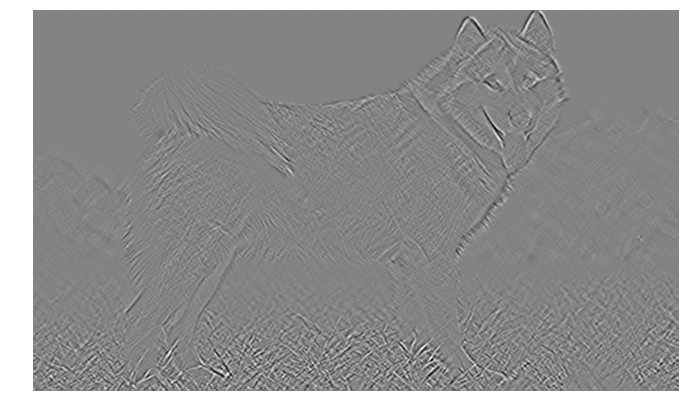

In [6]:
# Attempt to reconstruct the original image
deconv_img = ndimage.convolve(filtered_image, kernel.T)
display_image(deconv_img)

## ConvNet Visualisation

### Layer 1
The top 9x9 images are the reconstructed images. Below, we see patches of the images right where the activation fired strongly. 

A filter produces a high activation when it lines up with the pattern that the filter is looking for.

We see edges and colour blobs at different orientations. The results are not surprising because similar results were presented in  "Visualizing Higher-Layer Features of a Deep Network". 


<img src="figures/p4/filter-activations-layer-1-and-2.png" width="800" />



### Layer 2

In the second layer, the model is learning more complex patterns. It combines multiple edge patterns to make parallel lines, curves, circles, T-junctions etc. They cover a layer space of the image because it has bigger receptive field. 

**Notice** that the filters become invariant to small changes in the original image.

### Layer 3

Layer 3 has more complex invariances, capturing similar textures:
 - Mesh patterns (Row 1, Column 1)
 - Text (Row 2, Column 4). 
 - Human faces (Row 3, Column 3)

This layers sees $80\times 80$ patches in the input image. 

<img src="figures/p4/filter-activations-layer-3.png" width="800" />





### Layer 4

There is no pooling between the third and fourth layer, so the size of the receptive field is still $80\times 80$ in the input image.

Layer 4 shows significant variation, but is more class-specific and semantically related:
- Dog faces (Row 1, Column 1)
- Bird's legs (Row 4, Column 2)

<img src="figures/p4/filter-activations-layer-4-and-5.png" width="800" />

### Layer 5

The last convolutional layer before the classification layer so the image is becoming more object specific:

Layer 5 shows entire objects with significant pose variation:
- keyboards (Row 1, Column 11)
- dogs (Row 4).

## Feature Evolution during Training

Randomly chosen subset of features at epochs [1,2,5,10,20,30,40,64].

<img src="figures/p4/activations-during-training.png" width="900" />





- The lower layers of the model converge within a few epochs.
- The upper layers develop after a considerable number of epochs (40-50)
  - This shows how important it is to let the models train until fully converged

## Feature Invariance

- Another experiment was to determine the effect of translation, scaling and rotation of images
- Shift invariance because of the convolution and pooling
- No explicit way present rotation invariance
- Euclidean distance between feature vectors from the original and transformed images
  - Column 2 for layer 1, and Column 3 for layer 7

<img src="figures/p4/analysis-of-invariance.png" width="900" />





## Occlusion Sensitivy

Another issue: How do we know if the model is looking at the right regions for its classification? We can do occlusion sensitivity:
- Occlude part of the image
- Compute probability of correct class

The figure shows how the model is localising information used in the classification.

<img src="figures/p4/occlusion-predictions.png" width="700" />




The figure below shows how strongly the feature fires:

<img src="figures/p4/occlusion-feature-maps.png" width="700" />



## Correspondance Experiments

Does the blocking for certain parts of the image change the feature representation in a consistent way?

5 images of dogs are randomly selected. All with frontal poses. For each image $i$, compute the difference:

$$
\mathbf{\epsilon}_i^\ell = \mathbf{x}_i^\ell - \hat{\mathbf{x}}_i^\ell
$$
where 
- $\mathbf{x}_i^\ell$ is the feature map extracted at layer $\ell$ for the original image
- $\mathbf{\hat{x}}_i^\ell$ is the feature map extracted at layer $\ell$ for the occluded image

<img src="figures/p4/correspondance-experiments.png" width="800" />



Measure the consistency of the difference vector $\epsilon$ between all related image pairs $(i,j)$:

$$
\nabla_\ell = \sum_{i,j=1,i\neq j}^5 \mathcal{H}\left[sign\left(\epsilon_i^\ell\right), sign\left(\epsilon_j^\ell\right) \right]
$$
where
- $\mathcal{H}$ is the Hamming distance.

A lower value indicates greater consistency or tighter correspondence between the same object parts
 - e.g. blocking the left eye changes the feature representation in a consistent way

<img src="figures/p4/correspondance-results.png" width="400" />





Table 1. Measure of correspondence for different object
parts in 5 different dog images. The lower scores for the
eyes and nose (compared to random object parts) show the
model implicitly establishing some form of correspondence
of parts at layer 5 in the model. At layer 7, the scores
are more similar, perhaps due to upper layers trying to
discriminate between the different breeds of dog.

## Improving Performance

ConvNet visualisation is not only useful to gain insight in what a CNN is doing. It can also be used to improve the performance of the ConvNet.

Based on visualisations, changes were made to the AlexNet:
- reduced the 1st layer filter size from
- made the stride of the convolution 2, rather than 4.

This new architecture retains much more information

<img src="figures/p4/perf-results.png" width="600" />





Table 2. ImageNet 2012 classification error rates. The ∗
indicates models that were trained on both ImageNet 2011
and 2012 training sets.

This would suggest that the overall depth of the model is important for obtaining good performance. 

## Feature Generalization

- Fix layers 1-7 of our ImageNet-trained model, train softmax classifier on top
- The experiments compare our feature representation, learned from ImageNet, with the hand-crafted features used by other methods
- Generalises well to other datasets
  - Caltech-101
  - Caltech-256
  - PASCAL VOC 2012